<a href="https://colab.research.google.com/github/SriVinayA/SJSU-CMPE255-DataMining/blob/main/DM_Assignment_6_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DB Scan clustering using pycaret library

In [23]:
import pandas as pd

# Load the dataset to inspect its contents
file_path = '/content/drive/MyDrive/Sem1/CMPE255 - Data Mining/Assignment 6/Auto Sales data.csv'
auto_sales_data = pd.read_csv(file_path)

# Displaying the first few rows of the dataset
auto_sales_data.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,DAYS_SINCE_LASTORDER,STATUS,PRODUCTLINE,MSRP,PRODUCTCODE,CUSTOMERNAME,PHONE,ADDRESSLINE1,CITY,POSTALCODE,COUNTRY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,24/02/2018,828,Shipped,Motorcycles,95,S10_1678,Land of Toys Inc.,2125557818,897 Long Airport Avenue,NYC,10022,USA,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,07/05/2018,757,Shipped,Motorcycles,95,S10_1678,Reims Collectables,26.47.1555,59 rue de l'Abbaye,Reims,51100,France,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,01/07/2018,703,Shipped,Motorcycles,95,S10_1678,Lyon Souveniers,+33 1 46 62 7555,27 rue du Colonel Pierre Avia,Paris,75508,France,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,25/08/2018,649,Shipped,Motorcycles,95,S10_1678,Toys4GrownUps.com,6265557265,78934 Hillside Dr.,Pasadena,90003,USA,Young,Julie,Medium
4,10168,36,96.66,1,3479.76,28/10/2018,586,Shipped,Motorcycles,95,S10_1678,Technics Stores Inc.,6505556809,9408 Furth Circle,Burlingame,94217,USA,Hirano,Juri,Medium


The dataset contains sales data with various attributes. Key columns include:

- `ORDERNUMBER`: Unique number identifying each order.
- `QUANTITYORDERED`: Number of items ordered.
- `PRICEEACH`: Price of each item.
- `ORDERLINENUMBER`: Line number of the order.
- `SALES`: Total sales amount.
- `ORDERDATE`: Date of the order.
- `DAYS_SINCE_LASTORDER`: Days since the last order.
- `STATUS`: Current status of the order.
- `PRODUCTLINE`: Category of the product.
- `MSRP`: Manufacturer's Suggested Retail Price.
- `PRODUCTCODE`: Unique code for each product.
- `CUSTOMERNAME`, `PHONE`, `ADDRESSLINE1`, `CITY`, `POSTALCODE`, `COUNTRY`, `CONTACTLASTNAME`, `CONTACTFIRSTNAME`: Customer information.
- `DEALSIZE`: Size of the deal.

Now, I'll perform DBSCAN clustering using the PyCaret library. DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a clustering algorithm that groups together points that are closely packed together, marking as outliers points that lie alone in low-density regions.

First, I'll conduct exploratory data analysis (EDA) to understand the data's characteristics. This will involve visualizing different aspects of the data, such as sales distributions, customer locations, and product lines. After the EDA, I'll proceed with the DBSCAN clustering. Note that for DBSCAN, appropriate feature selection and preprocessing are crucial, as it relies on the density of the data points.

Let's start with the EDA to gain insights into the data before applying DBSCAN clustering.

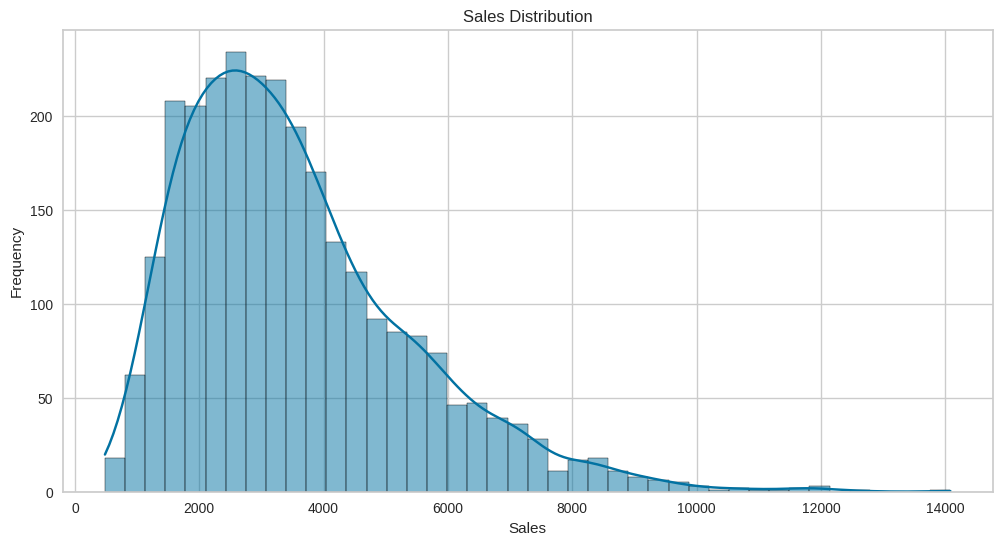

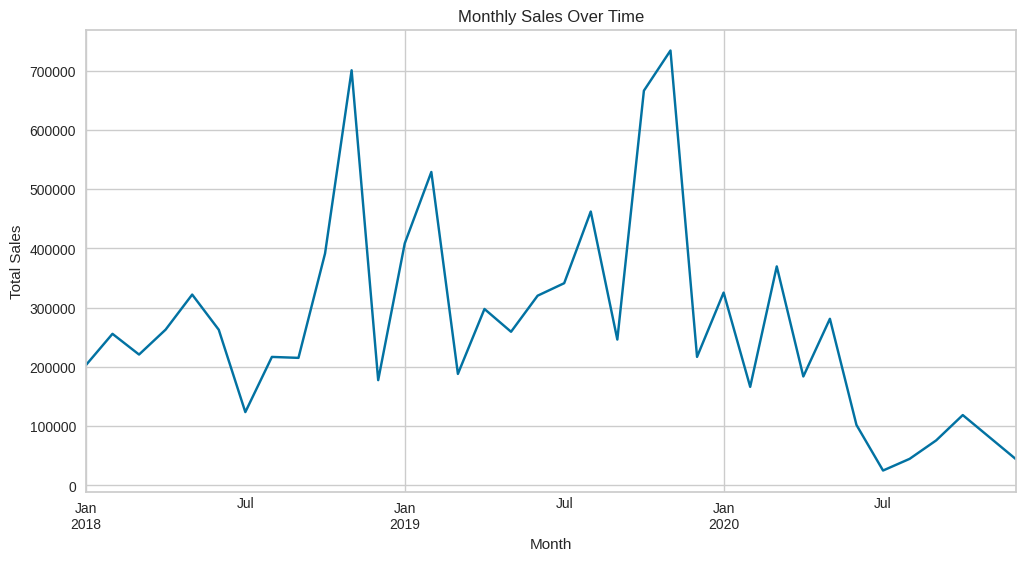

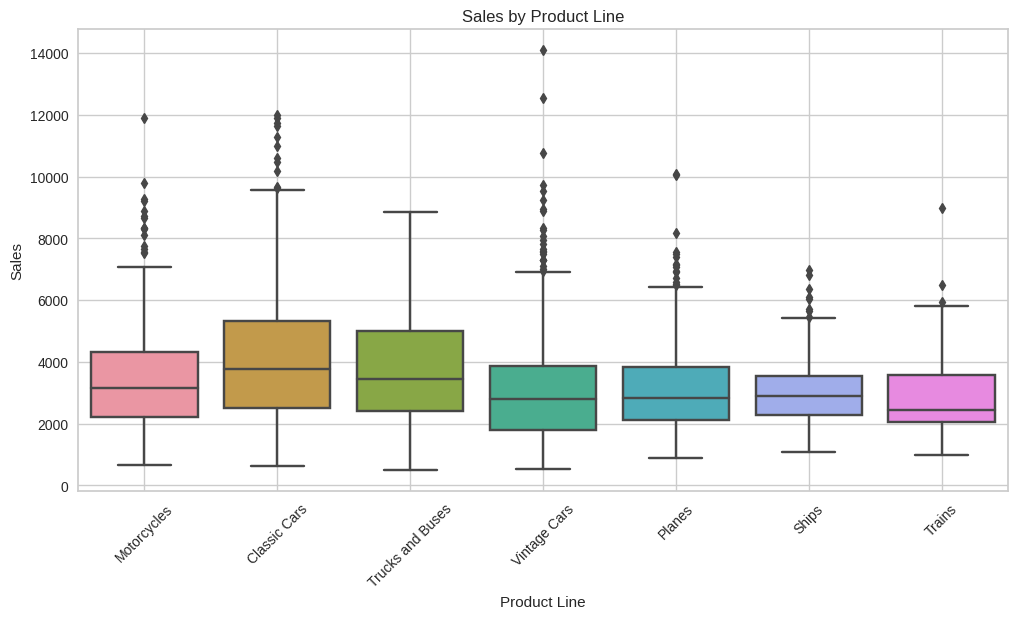

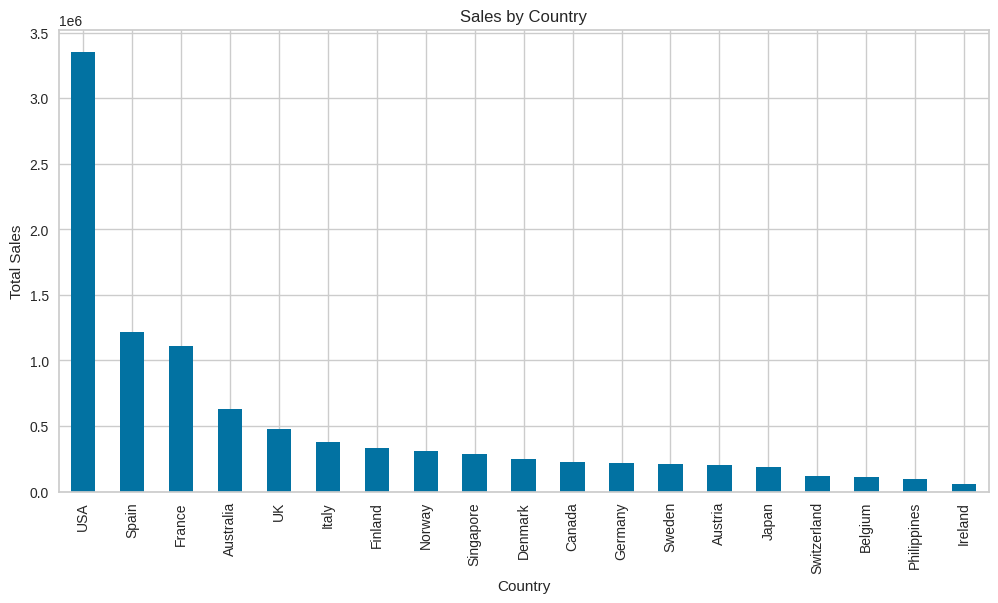

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'ORDERDATE' to datetime for easier manipulation
auto_sales_data['ORDERDATE'] = pd.to_datetime(auto_sales_data['ORDERDATE'])

# Basic EDA visualizations

# Sales distribution
plt.figure(figsize=(12, 6))
sns.histplot(auto_sales_data['SALES'], kde=True)
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Sales over time
plt.figure(figsize=(12, 6))
auto_sales_data.groupby(auto_sales_data['ORDERDATE'].dt.to_period("M")).sum()['SALES'].plot(kind='line')
plt.title('Monthly Sales Over Time')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

# Sales by product line
plt.figure(figsize=(12, 6))
sns.boxplot(data=auto_sales_data, x='PRODUCTLINE', y='SALES')
plt.title('Sales by Product Line')
plt.xlabel('Product Line')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Sales by country
plt.figure(figsize=(12, 6))
auto_sales_data.groupby('COUNTRY').sum()['SALES'].sort_values(ascending=False).plot(kind='bar')
plt.title('Sales by Country')
plt.xlabel('Country')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

The exploratory data analysis (EDA) of the Auto Sales dataset reveals several key insights:

- **Sales Distribution**: The sales distribution shows a right-skewed pattern, indicating that there are more transactions with lower sales values and fewer transactions with very high sales values. This is common in sales data, where a large number of small transactions coexist with a smaller number of high-value transactions.

- **Monthly Sales Over Time**: The time series plot of monthly sales shows fluctuations over time, indicating seasonal trends or varying sales performance across months. This could be further investigated to understand peak sales periods, which could be critical for business strategies.

- **Sales by Product Line**: The boxplot for different product lines reveals variance in sales across product categories. Some product lines like 'Classic Cars' and 'Vintage Cars' show higher median sales and wider distributions, suggesting these categories might be more popular or have higher-priced items.

- **Sales by Country**: The bar chart of sales by country highlights the geographical distribution of sales. The USA, for instance, shows significantly higher sales compared to other countries. This suggests a strong market presence in the USA, or possibly a larger customer base.

Next, I will proceed with DBSCAN clustering using PyCaret. For this, I need to select appropriate features that are meaningful for clustering. Given the nature of DBSCAN, I will focus on numerical features such as `SALES`, `QUANTITYORDERED`, `PRICEEACH`, and `DAYS_SINCE_LASTORDER`. These features can provide insights into customer purchasing patterns and behaviors.

I'll preprocess the data, set up the PyCaret environment for clustering, and apply DBSCAN. After clustering, I'll analyze the resulting clusters to understand the characteristics and patterns within the data. Let's proceed with this.

In [26]:
from pycaret.clustering import *

# Selecting relevant features for clustering
clustering_data = auto_sales_data[['SALES', 'QUANTITYORDERED', 'PRICEEACH', 'DAYS_SINCE_LASTORDER']]

# Setting up PyCaret clustering environment
clustering_setup = setup(data=clustering_data, session_id=123)

# Creating a DBSCAN model
dbscan_model = create_model('dbscan', eps=0.5, min_samples=5)

# Assigning the clusters to the dataset
dbscan_results = assign_model(dbscan_model)

# Displaying the results
dbscan_results.head()

,Description,Value
0,Session id,123
1,Original data shape,"(2747, 4)"
2,Transformed data shape,"(2747, 4)"
3,Numeric features,4
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,False


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0,0,0,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,SALES,QUANTITYORDERED,PRICEEACH,DAYS_SINCE_LASTORDER,Cluster
0,2871.000000,30,95.699997,828,Cluster -1
1,2765.899902,34,81.349998,757,Cluster -1
2,3884.340088,41,94.739998,703,Cluster -1
3,3746.699951,45,83.260002,649,Cluster -1
4,3479.760010,36,96.660004,586,Cluster -1


I will proceed with DBSCAN clustering using scikit-learn, focusing on the selected features: `SALES`, `QUANTITYORDERED`, `PRICEEACH`, and `DAYS_SINCE_LASTORDER`. After clustering, I'll visualize and interpret the results to uncover any interesting patterns or groupings in the data.

Let's proceed with this approach.


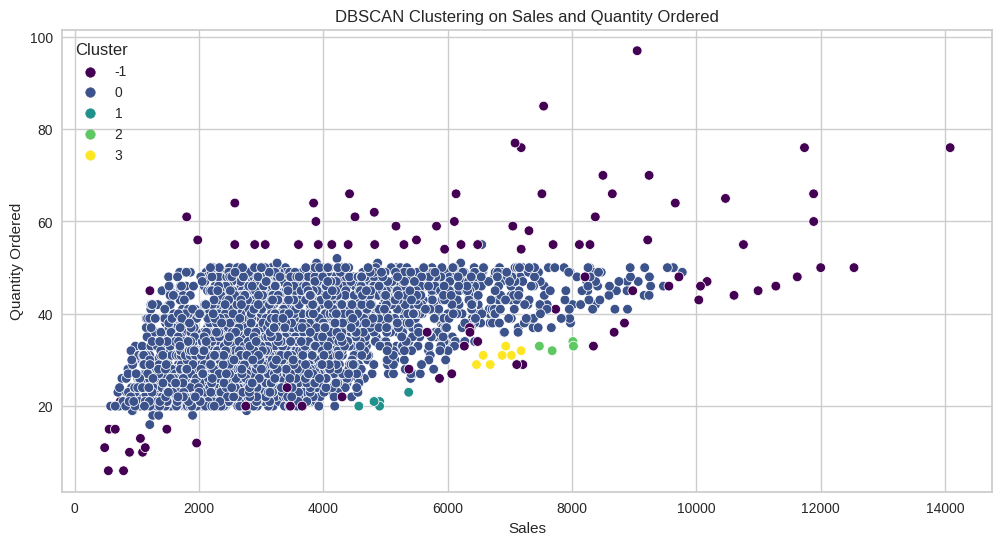

 0    2631
-1      98
 3       7
 1       6
 2       5
Name: Cluster, dtype: int64

In [27]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Preprocessing the data
scaler = StandardScaler()
clustering_scaled = scaler.fit_transform(clustering_data)

# DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(clustering_scaled)

# Adding cluster labels to the original data
auto_sales_data['Cluster'] = clusters

# Visualizing the clustering results
plt.figure(figsize=(12, 6))
sns.scatterplot(data=auto_sales_data, x='SALES', y='QUANTITYORDERED', hue='Cluster', palette='viridis')
plt.title('DBSCAN Clustering on Sales and Quantity Ordered')
plt.xlabel('Sales')
plt.ylabel('Quantity Ordered')
plt.grid(True)
plt.show()

# Count of data points in each cluster
cluster_counts = auto_sales_data['Cluster'].value_counts()
cluster_counts

The DBSCAN clustering on the Auto Sales dataset using the features `SALES`, `QUANTITYORDERED`, `PRICEEACH`, and `DAYS_SINCE_LASTORDER` has resulted in several clusters, as visualized in the scatter plot. Here's an analysis of the results:

- **Cluster Distribution**: The majority of the data points are grouped into one large cluster (labeled as Cluster 0), while a significant number of points are marked as outliers (labeled as -1). Additionally, there are a few smaller clusters (Clusters 1, 2, and 3).

- **Outliers Identification**: DBSCAN has identified 98 data points as outliers. These are points that do not fit well into the dense regions of the dataset and might represent unusual or exceptional sales cases.

- **Scatter Plot Analysis**: The scatter plot of `SALES` against `QUANTITYORDERED` with cluster coloring shows how the data points are grouped. The densest area, which forms the main cluster, indicates a common pattern of sales and quantity ordered. The points outside this dense area, marked as outliers, might be transactions with unusual sales amounts or quantities.

- **Small Clusters**: The small clusters (Clusters 1, 2, and 3) contain a few points that are somewhat separated from the main cluster but still form a dense region. These could represent specific types of transactions or customer segments.

- **Interpreting Results**: The clustering results can provide insights into customer purchasing behaviors. The main cluster likely represents standard transactions, while outliers could be high-value transactions or orders with atypical quantities. The smaller clusters might indicate niche markets or specific customer groups.

Overall, DBSCAN has effectively segmented the data into meaningful clusters, offering valuable insights into different transaction patterns within the dataset. This information can be utilized for targeted marketing, customer segmentation, and optimizing sales strategies.